In [1]:
import matplotlib
from matplotlib import pyplot as plt
import math
import random

import pymc3 as pm
import theano.tensor as tt
import theano

import numpy as np
from scipy import stats

# Plot functions

In [2]:
functions = [lambda x : x, 
             lambda x : 100 - x,
             lambda x : 50.5 + 49.5 * math.sin(math.pi / 2 + x / (5 * math.pi)),
             lambda x : random.randint(1, 101)]

In [3]:
def plot_function(func_num, plot=True, num_points=50):
    """
    Plot 50 (x,y) pairs for given function
    """
    points = []
    xs = []
    ys = []
    colors = ['maroon', 'blue', 'green', 'orange']
    for i in range(num_points):
        x = random.randint(1,101)
        y = functions[func_num](x)
    #     print(x, y)
        points.append((x,y))
        xs.append(x)
        ys.append(y)
    if plot:
        plt.figure()
        plt.scatter(xs, ys, color=colors[func_num])
    return (xs, ys)

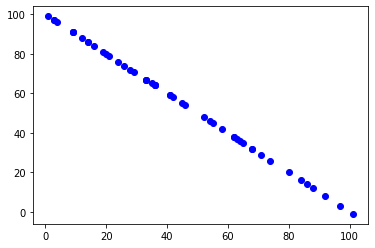

In [95]:
xs_1, ys_1 = plot_function(1, plot=True, num_points=50)
xs = list(np.copy(xs_1))
ys = list(np.copy(ys_1))

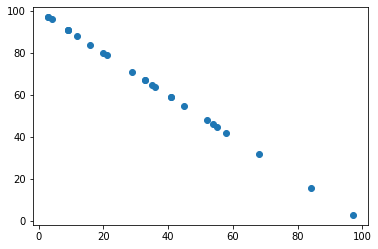

In [96]:
train_x = []
train_y = []
for i in range(25):
    ind = random.randint(0, len(xs)-1)
    x = xs.pop(ind)
    y = ys.pop(ind)
    
    train_x.append(x)
    train_y.append(y)
plt.scatter(train_x, train_y)

In [97]:
len(train_x), len(train_y), len(xs), len(ys)

(25, 25, 25, 25)

In [98]:
neg_traces = []

In [99]:
N= 25
X = train_x
Y = train_y

X_test = xs


# learning 

with pm.Model() as model:
    siga = 1
    sigb = 10
    
    print('Creating model...')
    
    a1 = pm.Normal('a1', mu=1, sigma=siga)
    b1 = pm.Normal('b1', mu=0, sigma=sigb)
    a2 = pm.Normal('a2', mu=-1, sigma=siga)
    b2 = pm.Normal('b2', mu=100, sigma=sigb)

    a = pm.Deterministic('a', tt.stack([a1, a2]))
    b = pm.Deterministic('b', tt.stack([b1, b2]))


    # Dirichlet distribution returns an array of probabilties
    # returns the prior distribution on the categorical distribution
    # alpha = (4,1) states that the categorical distribution is initially
    #         more heavily weighted towards the first value in the categorical
    #         array which is the positive slope
    p = pm.Dirichlet('p', a=np.array([4,1]))

    print('Training on 50 points...')
    
    for i in range(N):
        z = pm.Categorical('z_%u' % i, p=p)
        mu = a[z]*X[i] + b[z]
        y = pm.Normal('y_%u' % i, mu=mu, sigma=2, observed=Y[i])
        
    print('Generating test set...')
    
    for i in range(N):
        z_test = pm.Categorical('z_test_%u' % i, p=p)
        mu_test = a[z_test]*X_test[i] + b[z_test]
        y_test = pm.Normal('y_test_%u' % i, mu=mu_test, sigma=2)
    
    trace = pm.sample(100)
    neg_traces.append(trace)
        
print('Generating graph for next generation...')
Y_test = []
for i in range(N):
    y_pos = trace['y_test_%u'%i]
    Y_test.append(np.random.choice(y_pos))
plt.figure()

Creating model...


INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock


Training on 50 points...
Generating test set...


Only 100 samples in chain.
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12, z_13, z_14, z_15, z_16, z_17, z_18, z_19, z_20, z_21, z_22, z_23, z_24, z_test_0, z_test_1, z_test_2, z_test_3, z_test_4, z_test_5, z_test_6, z_test_7, z_test_8, z_test_9, z_test_10, z_test_11, z_test_12, z_test_13, z_test_14, z_test_15, z_test_16,

Generating graph for next generation...


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

(0, 100)

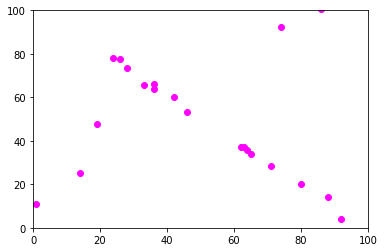

In [103]:
Y_test = []
for i in range(N):
    y_pos = trace['y_test_%u'%i]
    Y_test.append(np.random.choice(y_pos))
plt.figure()
plt.scatter(X_test, Y_test, color="#FF00FF")
plt.ylim([0,100])
plt.xlim([0,100])
# plt.savefig('neg_gen_%i.jpeg'%(i))

/Users/pkarnati/Library/Python/3.6/lib/python/site-packages/arviz/data/base.py:141: SyntaxWarning: More chains (400) than draws (2). Passed array should have shape (chains, draws, *shape)
  SyntaxWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x15e4580f0>],
      dtype=object)

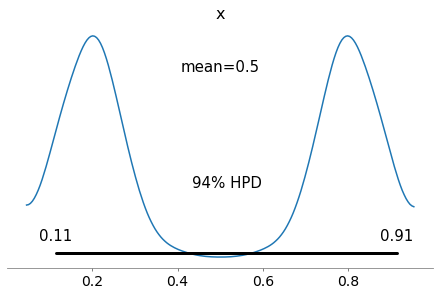

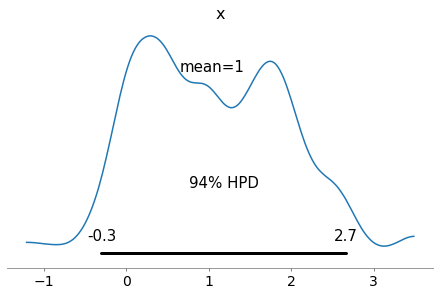

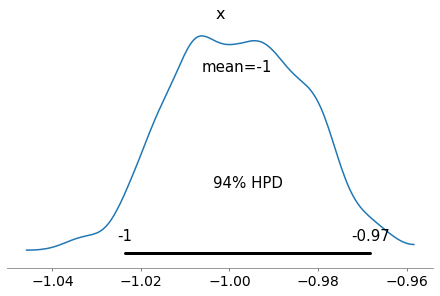

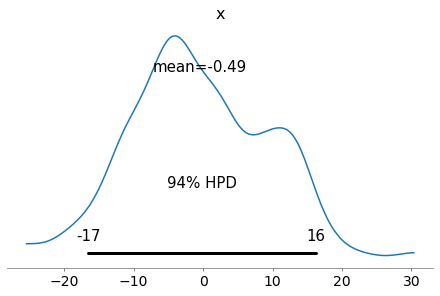

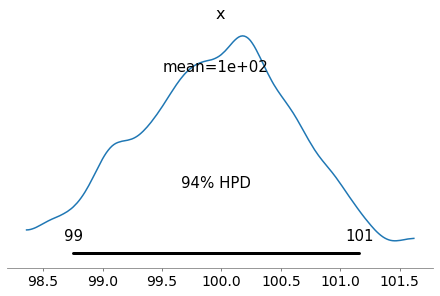

In [104]:
# p is low, p = probability of getting 1 for Bernoulli flip
pm.plot_posterior(trace['p'])
pm.plot_posterior(trace['a1'])
pm.plot_posterior(trace['a2'])
pm.plot_posterior(trace['b1'])
pm.plot_posterior(trace['b2'])

Creating model...


INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock


Training on 25 points...
Generating test set...


Only 100 samples in chain.
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_

Generating graph for next generation...


(0, 100)

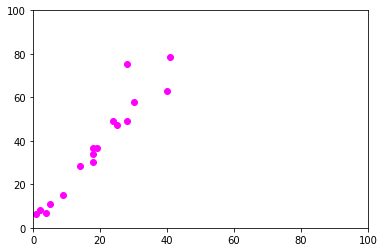

In [105]:
N = 25
X = X_test
Y = Y_test

new_x = [random.randint(1,101) for i in range(N)]

X_test = new_x


# learning 

with pm.Model() as model:
    siga = 1
    sigb = 10

    print('Creating model...')

    a1 = pm.Normal('a1', mu=1, sigma=siga)
    b1 = pm.Normal('b1', mu=0, sigma=sigb)
    a2 = pm.Normal('a2', mu=-1, sigma=siga)
    b2 = pm.Normal('b2', mu=100, sigma=sigb)

    a = pm.Deterministic('a', tt.stack([a1, a2]))
    b = pm.Deterministic('b', tt.stack([b1, b2]))


    # Dirichlet distribution returns an array of probabilties
    # returns the prior distribution on the categorical distribution
    # alpha = (4,1) states that the categorical distribution is initially
    #         more heavily weighted towards the first value in the categorical
    #         array which is the positive slope
    p = pm.Dirichlet('p', a=np.array([4,1]))

    print('Training on 25 points...')

    for i in range(N):
        z = pm.Categorical('z_%u' % i, p=p)
        mu = a[z]*X[i] + b[z]
        y = pm.Normal('y_%u' % i, mu=mu, sigma=2, observed=Y[i])

    print('Generating test set...')

    for i in range(N):
        z_test = pm.Categorical('z_test_%u' % i, p=p)
        mu_test = a[z_test]*X_test[i] + b[z_test]
        y_test = pm.Normal('y_test_%u' % i, mu=mu_test, sigma=2)

    trace = pm.sample(100)
    neg_traces.append(trace)

print('Generating graph for next generation...')
Y_test = []
for i in range(N):
    y_pos = trace['y_test_%u'%i]
    Y_test.append(np.random.choice(y_pos))
plt.figure()
plt.scatter(X_test, Y_test, color="#FF00FF")
plt.ylim([0,100])
plt.xlim([0,100])
# plt.savefig('neg/gen_%i.jpeg'%(gen))

/Users/pkarnati/Library/Python/3.6/lib/python/site-packages/arviz/data/base.py:141: SyntaxWarning: More chains (400) than draws (2). Passed array should have shape (chains, draws, *shape)
  SyntaxWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x165144c50>],
      dtype=object)

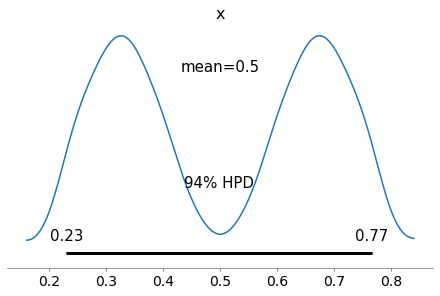

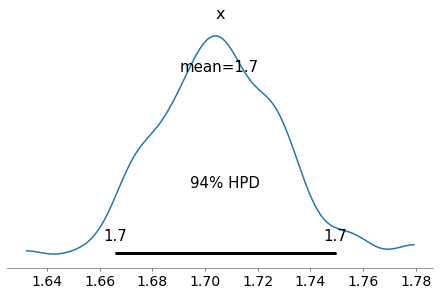

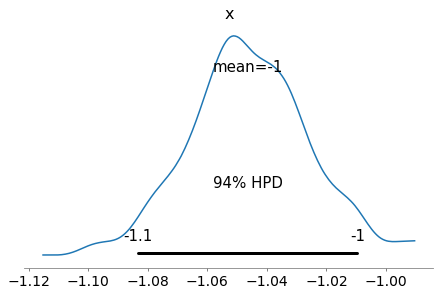

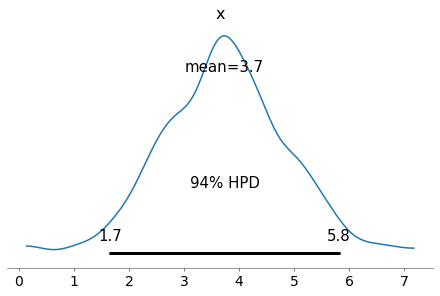

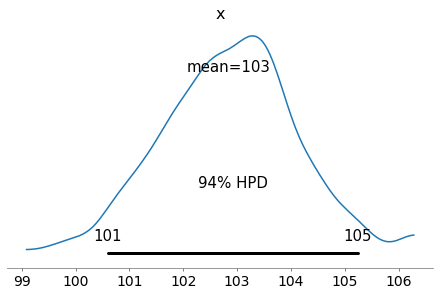

In [112]:
# p is low, p = probability of getting 1 for Bernoulli flip
pm.plot_posterior(trace['p'])
pm.plot_posterior(trace['a1'])
pm.plot_posterior(trace['a2'])
pm.plot_posterior(trace['b1'])
pm.plot_posterior(trace['b2'])

(0, 100)

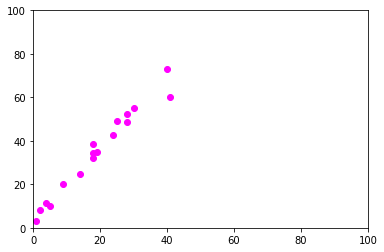

In [111]:
Y_test = []
for i in range(N):
    y_pos = trace['y_test_%u'%i]
    Y_test.append(np.random.choice(y_pos))
plt.figure()
plt.scatter(X_test, Y_test, color="#FF00FF")
plt.ylim([0,100])
plt.xlim([0,100])

Creating model...
Training on 25 points...
Generating test set...


Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12, z_13, z_14, z_15, z_16, z_17, z_18, z_19, z_20, z_21, z_22, z_23, z_24, z_test_0, z_test_1, z_test_2, z_test_3, z_test_4, z_test_5, z_test_6, z_test_7, z_test_8, z_test_9, z_test_10, z_test_11, z_test_12, z_test_13, z_test_14, z_test_15, z_test_16, z_test_17, z_test_18, z_test_19, z_test_20, z_test_21, z_test_22, z_test_23, z_test_24]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [00:59<00:00, 40.34draws/s]
/Users/pkarnati/Library/Python/3.6/lib/python/site-packages/xarray/core/nputils.py:223: RuntimeWarning: Al

Generating graph for next generation...
Creating model...
Training on 25 points...
Generating test set...


Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12, z_13, z_14, z_15, z_16, z_17, z_18, z_19, z_20, z_21, z_22, z_23, z_24, z_test_0, z_test_1, z_test_2, z_test_3, z_test_4, z_test_5, z_test_6, z_test_7, z_test_8, z_test_9, z_test_10, z_test_11, z_test_12, z_test_13, z_test_14, z_test_15, z_test_16, z_test_17, z_test_18, z_test_19, z_test_20, z_test_21, z_test_22, z_test_23, z_test_24]
Sampling 4 chains, 4 divergences: 100%|██████████| 2400/2400 [01:18<00:00, 30.64draws/s]
/Users/pkarnati/Library/Python/3.6/lib/python/site-packages/xarray/core/nputils.py:223: RuntimeWarning: Al

Generating graph for next generation...
Creating model...
Training on 25 points...
Generating test set...


Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12, z_13, z_14, z_15, z_16, z_17, z_18, z_19, z_20, z_21, z_22, z_23, z_24, z_test_0, z_test_1, z_test_2, z_test_3, z_test_4, z_test_5, z_test_6, z_test_7, z_test_8, z_test_9, z_test_10, z_test_11, z_test_12, z_test_13, z_test_14, z_test_15, z_test_16, z_test_17, z_test_18, z_test_19, z_test_20, z_test_21, z_test_22, z_test_23, z_test_24]
Sampling 4 chains, 23 divergences: 100%|██████████| 2400/2400 [01:20<00:00, 30.00draws/s]
/Users/pkarnati/Library/Python/3.6/lib/python/site-packages/xarray/core/nputils.py:223: RuntimeWarning: A

Generating graph for next generation...
Creating model...
Training on 25 points...
Generating test set...


Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12, z_13, z_14, z_15, z_16, z_17, z_18, z_19, z_20, z_21, z_22, z_23, z_24, z_test_0, z_test_1, z_test_2, z_test_3, z_test_4, z_test_5, z_test_6, z_test_7, z_test_8, z_test_9, z_test_10, z_test_11, z_test_12, z_test_13, z_test_14, z_test_15, z_test_16, z_test_17, z_test_18, z_test_19, z_test_20, z_test_21, z_test_22, z_test_23, z_test_24]
Sampling 4 chains, 18 divergences: 100%|██████████| 2400/2400 [01:17<00:00, 31.02draws/s]
/Users/pkarnati/Library/Python/3.6/lib/python/site-packages/xarray/core/nputils.py:223: RuntimeWarning: A

Generating graph for next generation...
Creating model...
Training on 25 points...
Generating test set...


Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12, z_13, z_14, z_15, z_16, z_17, z_18, z_19, z_20, z_21, z_22, z_23, z_24, z_test_0, z_test_1, z_test_2, z_test_3, z_test_4, z_test_5, z_test_6, z_test_7, z_test_8, z_test_9, z_test_10, z_test_11, z_test_12, z_test_13, z_test_14, z_test_15, z_test_16, z_test_17, z_test_18, z_test_19, z_test_20, z_test_21, z_test_22, z_test_23, z_test_24]
Sampling 4 chains, 15 divergences: 100%|██████████| 2400/2400 [01:20<00:00, 29.85draws/s]
/Users/pkarnati/Library/Python/3.6/lib/python/site-packages/xarray/core/nputils.py:223: RuntimeWarning: A

Generating graph for next generation...
Creating model...
Training on 25 points...
Generating test set...


Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12, z_13, z_14, z_15, z_16, z_17, z_18, z_19, z_20, z_21, z_22, z_23, z_24, z_test_0, z_test_1, z_test_2, z_test_3, z_test_4, z_test_5, z_test_6, z_test_7, z_test_8, z_test_9, z_test_10, z_test_11, z_test_12, z_test_13, z_test_14, z_test_15, z_test_16, z_test_17, z_test_18, z_test_19, z_test_20, z_test_21, z_test_22, z_test_23, z_test_24]
Sampling 4 chains, 21 divergences: 100%|██████████| 2400/2400 [01:33<00:00, 25.59draws/s]
/Users/pkarnati/Library/Python/3.6/lib/python/site-packages/xarray/core/nputils.py:223: RuntimeWarning: A

Generating graph for next generation...
Creating model...
Training on 25 points...
Generating test set...


Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12, z_13, z_14, z_15, z_16, z_17, z_18, z_19, z_20, z_21, z_22, z_23, z_24, z_test_0, z_test_1, z_test_2, z_test_3, z_test_4, z_test_5, z_test_6, z_test_7, z_test_8, z_test_9, z_test_10, z_test_11, z_test_12, z_test_13, z_test_14, z_test_15, z_test_16, z_test_17, z_test_18, z_test_19, z_test_20, z_test_21, z_test_22, z_test_23, z_test_24]
Sampling 4 chains, 34 divergences: 100%|██████████| 2400/2400 [01:15<00:00, 31.79draws/s]
/Users/pkarnati/Library/Python/3.6/lib/python/site-packages/xarray/core/nputils.py:223: RuntimeWarning: A

Generating graph for next generation...


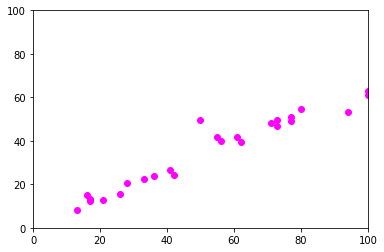

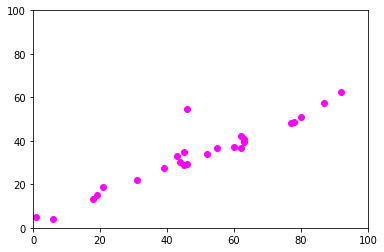

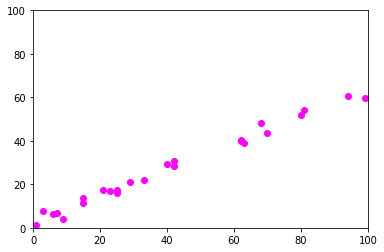

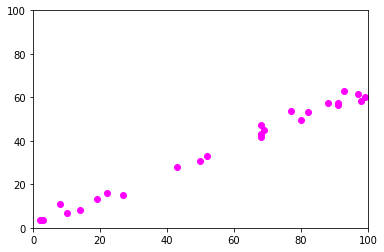

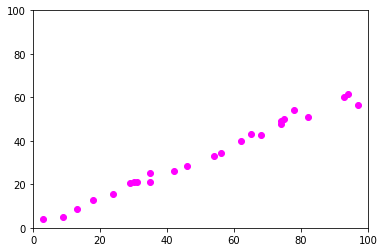

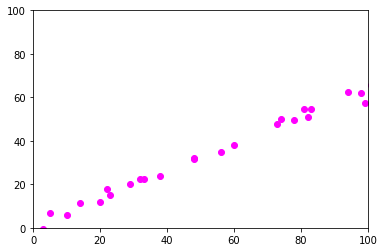

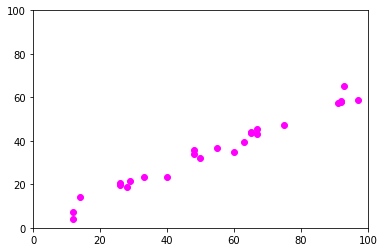

In [18]:
for gen in range(2, 9):
    N = 25
    X = X_test
    Y = Y_test
    
    new_x = [random.randint(1,101) for i in range(N)]

    X_test = new_x


    # learning 

    with pm.Model() as model:
        siga = 1
        sigb = 10

        print('Creating model...')

        a1 = pm.Normal('a1', mu=1, sigma=siga)
        b1 = pm.Normal('b1', mu=0, sigma=sigb)
        a2 = pm.Normal('a2', mu=-1, sigma=siga)
        b2 = pm.Normal('b2', mu=100, sigma=sigb)

        a = pm.Deterministic('a', tt.stack([a1, a2]))
        b = pm.Deterministic('b', tt.stack([b1, b2]))


        # Dirichlet distribution returns an array of probabilties
        # returns the prior distribution on the categorical distribution
        # alpha = (4,1) states that the categorical distribution is initially
        #         more heavily weighted towards the first value in the categorical
        #         array which is the positive slope
        p = pm.Dirichlet('p', a=np.array([4,1]))

        print('Training on 25 points...')

        for i in range(N):
            z = pm.Categorical('z_%u' % i, p=p)
            mu = a[z]*X[i] + b[z]
            y = pm.Normal('y_%u' % i, mu=mu, sigma=2, observed=Y[i])

        print('Generating test set...')

        for i in range(N):
            z_test = pm.Categorical('z_test_%u' % i, p=p)
            mu_test = a[z_test]*X_test[i] + b[z_test]
            y_test = pm.Normal('y_test_%u' % i, mu=mu_test, sigma=2)

        trace = pm.sample(100)

    print('Generating graph for next generation...')
    Y_test = []
    for i in range(N):
        y_pos = trace['y_test_%u'%i]
        Y_test.append(np.random.choice(y_pos))
    plt.figure()
    plt.scatter(X_test, Y_test, color="#FF00FF")
    plt.ylim([0,100])
    plt.xlim([0,100])
    plt.savefig('neg/gen_%i.jpeg'%(gen))

/Users/pkarnati/Library/Python/3.6/lib/python/site-packages/arviz/data/base.py:141: SyntaxWarning: More chains (400) than draws (2). Passed array should have shape (chains, draws, *shape)
  SyntaxWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x136430780>],
      dtype=object)

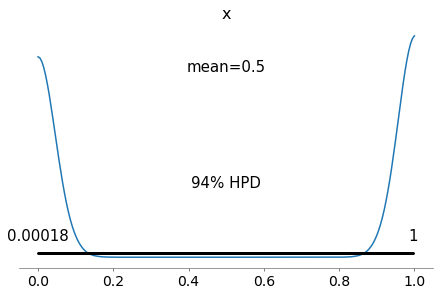

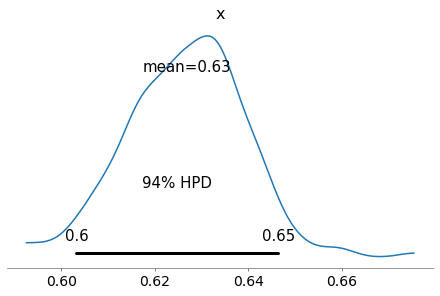

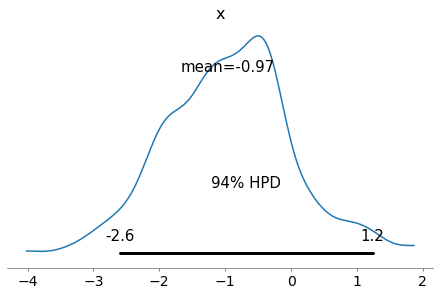

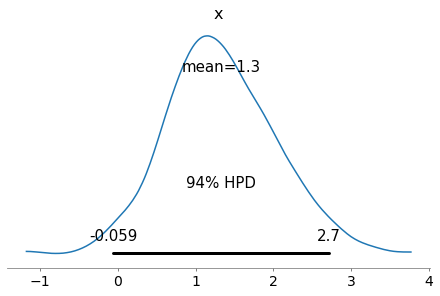

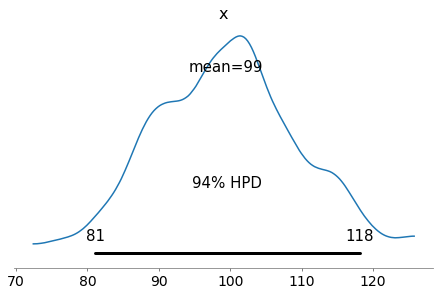

In [27]:
pm.plot_posterior(trace['p'])
pm.plot_posterior(trace['a1'])
pm.plot_posterior(trace['a2'])
pm.plot_posterior(trace['b1'])
pm.plot_posterior(trace['b2'])

Second function

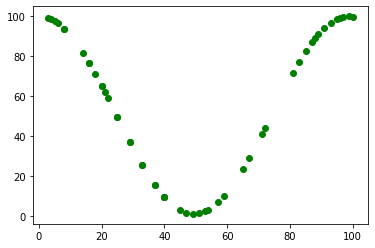

In [61]:
xs_1, ys_1 = plot_function(2, plot=True, num_points=50)
xs = list(np.copy(xs_1))
ys = list(np.copy(ys_1))

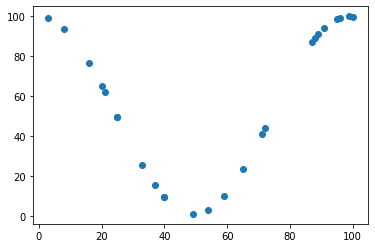

In [62]:
train_x = []
train_y = []
for i in range(25):
    ind = random.randint(0, len(xs)-1)
    x = xs.pop(ind)
    y = ys.pop(ind)
    
    train_x.append(x)
    train_y.append(y)
plt.scatter(train_x, train_y)
plt.savefig('poly/gen_0.jpeg')

In [63]:
len(xs), len(ys), len(train_x), len(train_y)

(25, 25, 25, 25)

In [64]:
poly_traces = []

Creating model...


INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock


Training on 25 points...
Generating test set...


Only 100 samples in chain.
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12, z_13, z_14, z_15, z_16, z_17, z_18, z_19, z_20, z_21, z_22, z_23, z_24, z_test_0, z_test_1, z_test_2, z_test_3, z_test_4, z_test_5, z_test_6, z_test_7, z_test_8, z_test_9, z_test_10, z_test_11, z_test_12, z_test_13, z_test_14, z_test_15, z_test_16,

Generating graph for next generation...


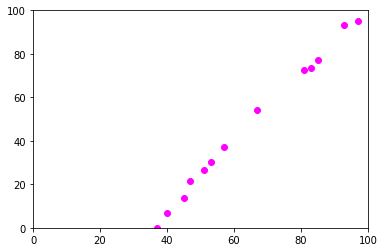

In [65]:
N= 25
X = train_x
Y = train_y

X_test = xs


# learning 

with pm.Model() as model:
    siga = 1
    sigb = 10
    
    print('Creating model...')
    
    a1 = pm.Normal('a1', mu=1, sigma=siga)
    b1 = pm.Normal('b1', mu=0, sigma=sigb)
    a2 = pm.Normal('a2', mu=-1, sigma=siga)
    b2 = pm.Normal('b2', mu=100, sigma=sigb)

    a = pm.Deterministic('a', tt.stack([a1, a2]))
    b = pm.Deterministic('b', tt.stack([b1, b2]))


    # Dirichlet distribution returns an array of probabilties
    # returns the prior distribution on the categorical distribution
    # alpha = (4,1) states that the categorical distribution is initially
    #         more heavily weighted towards the first value in the categorical
    #         array which is the positive slope
    p = pm.Dirichlet('p', a=np.array([2,1]))

    print('Training on 25 points...')
    
    for i in range(N):
        z = pm.Categorical('z_%u' % i, p=p)
        mu = a[z]*X[i] + b[z]
        y = pm.Normal('y_%u' % i, mu=mu, sigma=2, observed=Y[i])
        
    print('Generating test set...')
    
    for i in range(N):
        z_test = pm.Categorical('z_test_%u' % i, p=p)
        mu_test = a[z_test]*X_test[i] + b[z_test]
        y_test = pm.Normal('y_test_%u' % i, mu=mu_test, sigma=2)
    
    trace = pm.sample(100)
    poly_traces.append(trace)
        
print('Generating graph for next generation...')
Y_test = []
for i in range(N):
    y_pos = trace['y_test_%u'%i]
    Y_test.append(np.random.choice(y_pos))
plt.figure()
plt.scatter(X_test, Y_test, color="#FF00FF")
plt.ylim([0,100])
plt.xlim([0,100])
plt.savefig('poly/gen_1.jpeg')

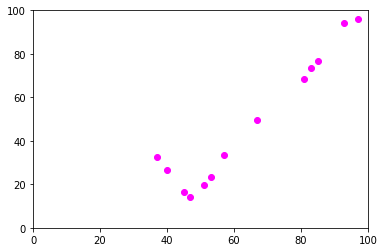

In [85]:
Y_test = []
for i in range(N):
    y_pos = trace['y_test_%u'%i]
    Y_test.append(np.random.choice(y_pos))
plt.figure()
plt.scatter(X_test, Y_test, color="#FF00FF")
plt.ylim([0,100])
plt.xlim([0,100])
plt.savefig('poly/gen_1.jpeg')

/Users/pkarnati/Library/Python/3.6/lib/python/site-packages/arviz/data/base.py:141: SyntaxWarning: More chains (400) than draws (2). Passed array should have shape (chains, draws, *shape)
  SyntaxWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1248394e0>],
      dtype=object)

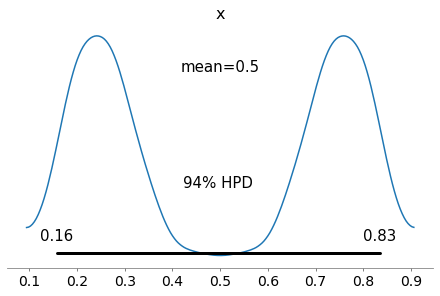

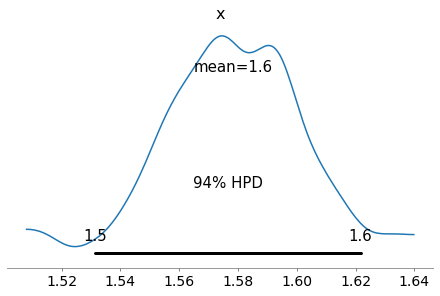

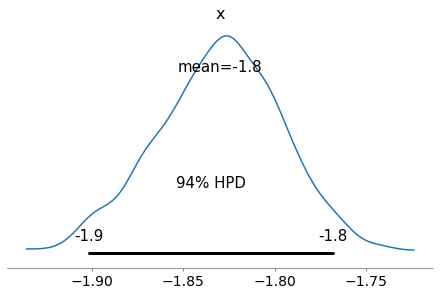

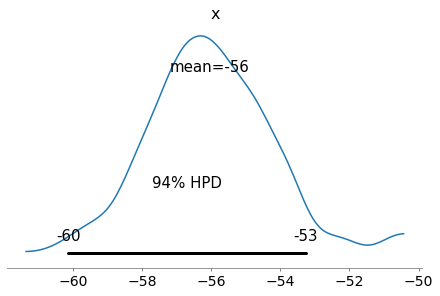

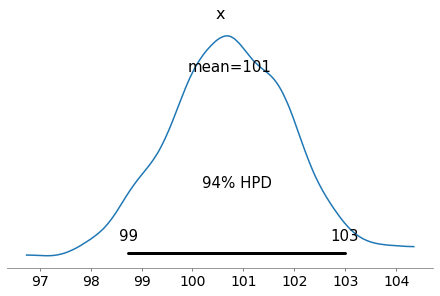

In [86]:
# p is low, p = probability of getting 1 for Bernoulli flip
pm.plot_posterior(trace['p'])
pm.plot_posterior(trace['a1'])
pm.plot_posterior(trace['a2'])
pm.plot_posterior(trace['b1'])
pm.plot_posterior(trace['b2'])

Creating model...


INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock


Training on 25 points...
Generating test set...


Only 100 samples in chain.
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12, z_13, z_14, z_15, z_16, z_17, z_18, z_19, z_20, z_21, z_22, z_23, z_24, z_test_0, z_test_1, z_test_2, z_te

Generating graph for next generation...
Creating model...


INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock


Training on 25 points...
Generating test set...


Only 100 samples in chain.
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12, z_13, z_14, z_15, z_16, z_17, z_18, z_19, z_20, z_21, z_22, z_23, z_24, z_test_0, z_test_1, z_test_2, z_te

Generating graph for next generation...
Creating model...


INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock


Training on 25 points...
Generating test set...


Only 100 samples in chain.
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12, z_13, z_14, z_15, z_16, z_17, z_18, z_19, z_20, z_21, z_22, z_23, z_24, z_test_0, z_test_1, z_test_2, z_te

Generating graph for next generation...
Creating model...


INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock


Training on 25 points...
Generating test set...


Only 100 samples in chain.
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_

Generating graph for next generation...
Creating model...


INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock


Training on 25 points...
Generating test set...


Only 100 samples in chain.
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_

Generating graph for next generation...
Creating model...


INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock


Training on 25 points...
Generating test set...


Only 100 samples in chain.
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12, z_13, z_14, z_15, z_16, z_17, z_18, z_19, z_20, z_21, z_22, z_23, z_24, z_test_0, z_test_1, z_test_2, z_te

Generating graph for next generation...
Creating model...


INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock


Training on 25 points...
Generating test set...


Only 100 samples in chain.
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_

Generating graph for next generation...


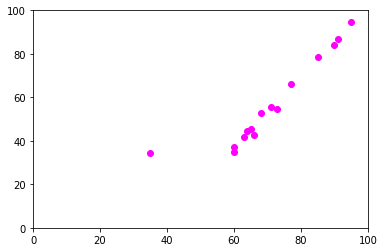

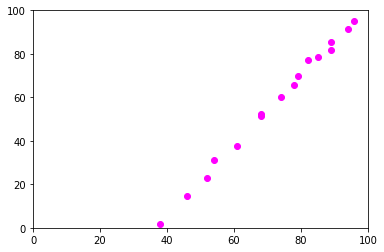

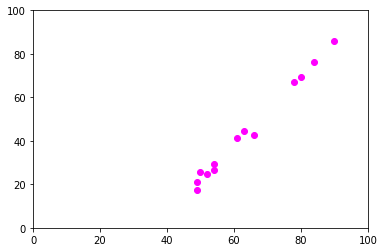

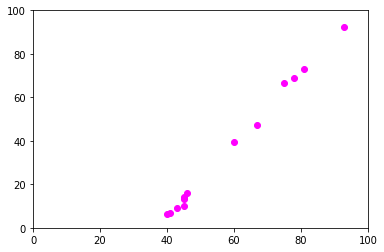

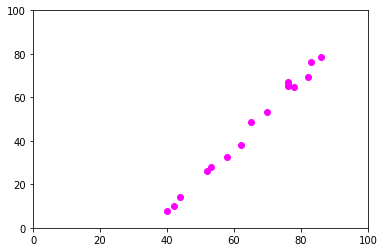

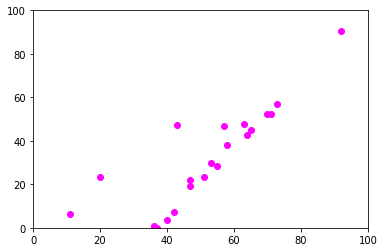

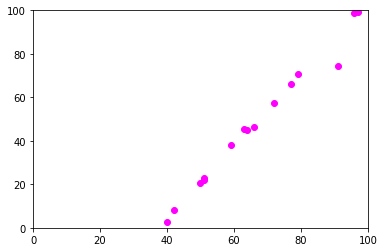

In [87]:
for gen in range(2, 9):
    N = 25
    X = X_test
    Y = Y_test
    
    new_x = [random.randint(1,101) for i in range(N)]

    X_test = new_x


    # learning 

    with pm.Model() as model:
        siga = 1
        sigb = 10

        print('Creating model...')

        a1 = pm.Normal('a1', mu=1, sigma=siga)
        b1 = pm.Normal('b1', mu=0, sigma=sigb)
        a2 = pm.Normal('a2', mu=-1, sigma=siga)
        b2 = pm.Normal('b2', mu=100, sigma=sigb)

        a = pm.Deterministic('a', tt.stack([a1, a2]))
        b = pm.Deterministic('b', tt.stack([b1, b2]))


        # Dirichlet distribution returns an array of probabilties
        # returns the prior distribution on the categorical distribution
        # alpha = (4,1) states that the categorical distribution is initially
        #         more heavily weighted towards the first value in the categorical
        #         array which is the positive slope
        p = pm.Dirichlet('p', a=np.array([4,1]))

        print('Training on 25 points...')

        for i in range(N):
            z = pm.Categorical('z_%u' % i, p=p)
            mu = a[z]*X[i] + b[z]
            y = pm.Normal('y_%u' % i, mu=mu, sigma=2, observed=Y[i])

        print('Generating test set...')

        for i in range(N):
            z_test = pm.Categorical('z_test_%u' % i, p=p)
            mu_test = a[z_test]*X_test[i] + b[z_test]
            y_test = pm.Normal('y_test_%u' % i, mu=mu_test, sigma=2)

        trace = pm.sample(100)
        poly_traces.append(trace)

    print('Generating graph for next generation...')
    Y_test = []
    for i in range(N):
        y_pos = trace['y_test_%u'%i]
        Y_test.append(np.random.choice(y_pos))
    plt.figure()
    plt.scatter(X_test, Y_test, color="#FF00FF")
    plt.ylim([0,100])
    plt.xlim([0,100])
    plt.savefig('poly/gen_%i.jpeg'%(gen))

Third Function

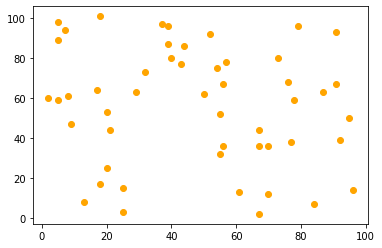

In [88]:
xs_1, ys_1 = plot_function(3, plot=True, num_points=50)
xs = list(np.copy(xs_1))
ys = list(np.copy(ys_1))

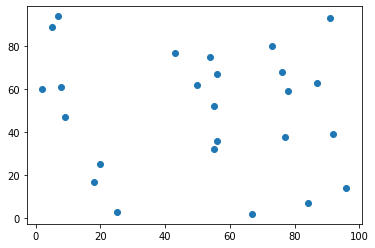

In [89]:
train_x = []
train_y = []
for i in range(25):
    ind = random.randint(0, len(xs)-1)
    x = xs.pop(ind)
    y = ys.pop(ind)
    
    train_x.append(x)
    train_y.append(y)
plt.scatter(train_x, train_y)
plt.savefig('ran/gen_0.jpeg')

In [90]:
len(xs), len(ys), len(train_x), len(train_y)

(25, 25, 25, 25)

In [91]:
ran_traces = []

Creating model...


INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock


Training on 25 points...
Generating test set...


Only 100 samples in chain.
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [y_test_24, y_test_23, y_test_22, y_test_21, y_test_20, y_test_19, y_test_18, y_test_17, y_test_16, y_test_15, y_test_14, y_test_13, y_test_12, y_test_11, y_test_10, y_test_9, y_test_8, y_test_7, y_test_6, y_test_5, y_test_4, y_test_3, y_test_2, y_test_1, y_test_0, p, b2, a2, b1, a1]
>BinaryGibbsMetropolis: [z_0, z_1, z_2, z_3, z_4, z_5, z_

Generating graph for next generation...


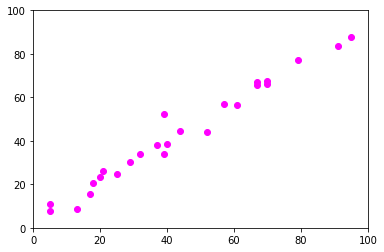

In [92]:
N= 25
X = train_x
Y = train_y

X_test = xs


# learning 

with pm.Model() as model:
    siga = 1
    sigb = 10
    
    print('Creating model...')
    
    a1 = pm.Normal('a1', mu=1, sigma=siga)
    b1 = pm.Normal('b1', mu=0, sigma=sigb)
    a2 = pm.Normal('a2', mu=-1, sigma=siga)
    b2 = pm.Normal('b2', mu=100, sigma=sigb)

    a = pm.Deterministic('a', tt.stack([a1, a2]))
    b = pm.Deterministic('b', tt.stack([b1, b2]))


    # Dirichlet distribution returns an array of probabilties
    # returns the prior distribution on the categorical distribution
    # alpha = (4,1) states that the categorical distribution is initially
    #         more heavily weighted towards the first value in the categorical
    #         array which is the positive slope
    p = pm.Dirichlet('p', a=np.array([2,1]))

    print('Training on 25 points...')
    
    for i in range(N):
        z = pm.Categorical('z_%u' % i, p=p)
        mu = a[z]*X[i] + b[z]
        y = pm.Normal('y_%u' % i, mu=mu, sigma=2, observed=Y[i])
        
    print('Generating test set...')
    
    for i in range(N):
        z_test = pm.Categorical('z_test_%u' % i, p=p)
        mu_test = a[z_test]*X_test[i] + b[z_test]
        y_test = pm.Normal('y_test_%u' % i, mu=mu_test, sigma=2)
    
    trace = pm.sample(100)
    ran_traces.append(trace)
        
print('Generating graph for next generation...')
Y_test = []
for i in range(N):
    y_pos = trace['y_test_%u'%i]
    Y_test.append(np.random.choice(y_pos))
plt.figure()
plt.scatter(X_test, Y_test, color="#FF00FF")
plt.ylim([0,100])
plt.xlim([0,100])
plt.savefig('ran/gen_1.jpeg')

/Users/pkarnati/Library/Python/3.6/lib/python/site-packages/arviz/data/base.py:141: SyntaxWarning: More chains (400) than draws (2). Passed array should have shape (chains, draws, *shape)
  SyntaxWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1303d8dd8>],
      dtype=object)

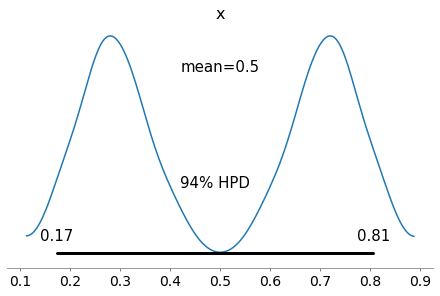

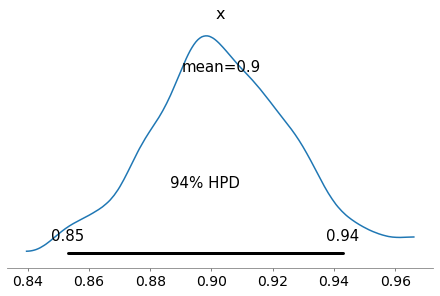

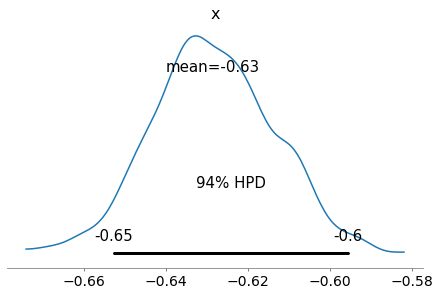

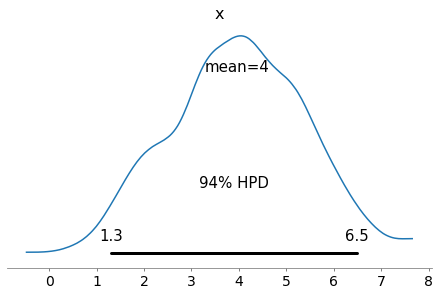

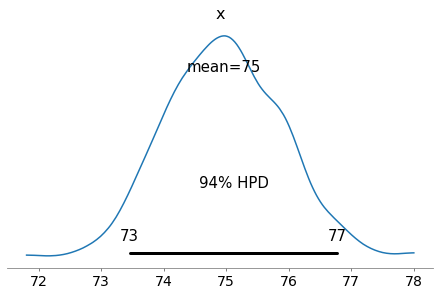

In [93]:
# p is low, p = probability of getting 1 for Bernoulli flip
pm.plot_posterior(trace['p'])
pm.plot_posterior(trace['a1'])
pm.plot_posterior(trace['a2'])
pm.plot_posterior(trace['b1'])
pm.plot_posterior(trace['b2'])

In [94]:
for gen in range(2, 9):
    N = 25
    X = X_test
    Y = Y_test
    
    new_x = [random.randint(1,101) for i in range(N)]

    X_test = new_x


    # learning 

    with pm.Model() as model:
        siga = 1
        sigb = 10

        print('Creating model...')

        a1 = pm.Normal('a1', mu=1, sigma=siga)
        b1 = pm.Normal('b1', mu=0, sigma=sigb)
        a2 = pm.Normal('a2', mu=-1, sigma=siga)
        b2 = pm.Normal('b2', mu=100, sigma=sigb)

        a = pm.Deterministic('a', tt.stack([a1, a2]))
        b = pm.Deterministic('b', tt.stack([b1, b2]))


        # Dirichlet distribution returns an array of probabilties
        # returns the prior distribution on the categorical distribution
        # alpha = (4,1) states that the categorical distribution is initially
        #         more heavily weighted towards the first value in the categorical
        #         array which is the positive slope
        p = pm.Dirichlet('p', a=np.array([4,1]))

        print('Training on 25 points...')

        for i in range(N):
            z = pm.Categorical('z_%u' % i, p=p)
            mu = a[z]*X[i] + b[z]
            y = pm.Normal('y_%u' % i, mu=mu, sigma=2, observed=Y[i])

        print('Generating test set...')

        for i in range(N):
            z_test = pm.Categorical('z_test_%u' % i, p=p)
            mu_test = a[z_test]*X_test[i] + b[z_test]
            y_test = pm.Normal('y_test_%u' % i, mu=mu_test, sigma=2)

        trace = pm.sample(100)
        ran_traces.append(trace)

    print('Generating graph for next generation...')
    Y_test = []
    for i in range(N):
        y_pos = trace['y_test_%u'%i]
        Y_test.append(np.random.choice(y_pos))
    plt.figure()
    plt.scatter(X_test, Y_test, color="#FF00FF")
    plt.ylim([0,100])
    plt.xlim([0,100])
    plt.savefig('ran/gen_%i.jpeg'%(gen))

Creating model...


INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock


Training on 25 points...
Generating test set...


Only 100 samples in chain.
INFO (theano.gof.compilelock): Refreshing lock /Users/pkarnati/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock


KeyboardInterrupt: 

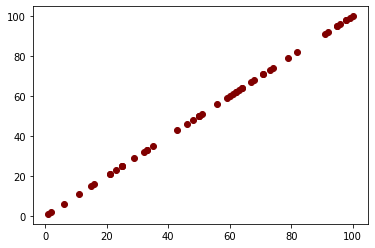

In [114]:
xs_1, ys_1 = plot_function(0, plot=True, num_points=50)
xs = list(np.copy(xs_1))
ys = list(np.copy(ys_1))

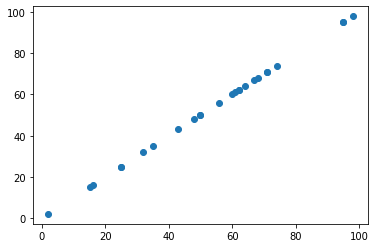

In [115]:
train_x = []
train_y = []
for i in range(25):
    ind = random.randint(0, len(xs)-1)
    x = xs.pop(ind)
    y = ys.pop(ind)
    
    train_x.append(x)
    train_y.append(y)
plt.scatter(train_x, train_y)
plt.savefig('pos_gen_0.jpeg')